In [1]:
import os
import sys

curdir = '/home/frederik/Dropbox/GitHub/Magritte/tests/development/'
datdir = f'{curdir}../data/'
moddir = f'{curdir}../models/'
resdir = f'{curdir}../results/'
sys.path.append(f'{curdir}/../../')

import numpy             as np
import scipy             as sp
import healpy            as hp
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.mesher   as mesher
import magritte.core     as magritte

from scipy.interpolate import interp1d

# Setup 1: VZ 1, 3D mesher
---

In [2]:
dimension = 3
nrays     = 12*3**2
nspecs    = 5
nlspecs   = 1
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 20.0     # [K]
turb   = 150.00   # [.]

a_or_b = 'a'

get_X_mol = {
    'a' : 1.0E-8,
    'b' : 1.0E-6
}

scale_max = 0.11 * r_out
scale_min = 0.11 * r_in
scale_cte = 0.11 * r_in
scale_fun = f'{scale_cte / r_in**2} * (x*x + y*y + z*z)'

In [3]:
meshName = f'{moddir}/vanZadelhoff_1_3D_mesher.vtk'

mesher.create_mesh_from_function(
    meshName       = meshName,
    boundary       = mesher.boundary_sphere_in_sphere(
                         radius_in  = r_in,
                         radius_out = r_out),
    scale_min      = scale_min,
    scale_max      = scale_max,
    scale_function = scale_fun )

mesh = mesher.Mesh(meshName)

Info    : Running 'gmsh /home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.geo -3 -saveall -o /home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.vtk' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Wed Nov 25 16:52:16 2020
Info    : Reading '/home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.geo'...
Info    : Done reading '/home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.geo'
Info    : Meshing 1D...
Info    : Meshing curve 101 (Circle)
Info    : Meshing curve 102 (Circle)
Info    : Meshing curve 103 (Circle)
Info    : Meshing curve 104 (Circle)
Info    : Meshing curve 105 (Circle)
Info    : Meshing curve 106 (Circle)
Info    : Meshing curve 107 (Circle)
Info    : Meshing curve 108 (Circle)
Info    : Meshing curve 109 (Circle)
Info    : Meshing curve 110 (Circle)
Info    : Meshing curve 111 (Circle)
Info    : M

In [4]:
npoints = len(mesh.points)
nbs     = [n for sublist in mesh.neighbors for n in sublist]
n_nbs   = [len(sublist) for sublist in mesh.neighbors]

rs = np.linalg.norm(mesh.points, axis=1)

modelName = f'vanZadelhoff_1{a_or_b}_3D_mesher'
modelFile = f'{moddir}{modelName}.hdf5'
lamdaFile = f'{datdir}test.txt'

X_mol = get_X_mol[a_or_b]

In [5]:
def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

In [6]:
def nTT (r):
    return X_mol * nH2(r)

In [7]:
model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set(mesh.points)
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()

# Setup 2: VZ 1, single ray
---

In [2]:
dimension = 1
npoints   = 25
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 2.0E+01  # [K]
turb   = 1.5E+02  # [m/s]

get_X_mol = {
    'a' : 1.0E-8,
    'b' : 1.0E-6
}

# rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)
rs = np.linspace (r_in, r_out, npoints, endpoint=True)


def create_model (a_or_b):
    """
    Create a model file for the density distribution benchmark, single ray.
    """

    modelName = f'density_distribution_VZ{a_or_b}_single_ray'
    modelFile = f'{moddir}{modelName}.hdf5'
    lamdaFile = f'{datdir}test.txt'

    X_mol = get_X_mol[a_or_b]

    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)

    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(False)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set([[0, 0, 0] for i in range(npoints)])

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_uniform_rays            (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()

    return magritte.Model (modelFile)

In [2]:
model = create_model ('a')

# Setup 3: all constant, single ray
---

In [118]:
dimension = 1
npoints   = 3
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

nH2  = 1.0E+12                 # [m^-3]
nTT  = 1.0E+03                 # [m^-3]
temp = 4.5E+00                 # [K]
turb = 0.0E+00                 # [m/s]
dx   = 1.0E+12                 # [m]
dv   = 0.0E+00 / magritte.CC   # [fraction of speed of light]

rs = np.array([i*dx for i in range(npoints)])

def create_model ():
    """
    Create a model file for the all_constant benchmark, single ray.
    """

    modelName = f'all_constant_single_ray'
    modelFile = f'{moddir}{modelName}.hdf5'
    lamdaFile = f'{datdir}test.txt'

    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(False)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)

    model.geometry.points.position.set([[i*dx, 0, 0] for i in range(npoints)])
    model.geometry.points.velocity.set([[i*dv, 0, 0] for i in range(npoints)])

    model.chemistry.species.abundance = [[     0.0,    nTT,  nH2,  0.0,      1.0] for _ in range(npoints)]
    model.chemistry.species.symbol    =  ['dummy0', 'test', 'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_uniform_rays            (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()

    return magritte.Model(modelFile)

In [119]:
model = create_model()

In [120]:
ld = model.lines.lineProducingSpecies[0].linedata

k = 0

frq_ = ld.frequency[k]
pop_ = tools.LTEpop         (ld, temp) * nTT
phi_ = tools.profile        (ld, k, temp, (turb/magritte.CC)**2, frq_)
eta_ = tools.lineEmissivity (ld, pop_)[k] * phi_
chi_ = tools.lineOpacity    (ld, pop_)[k] * phi_
src_ = tools.lineSource     (ld, pop_)[k]
bdy_ = tools.I_CMB          (frq_)

def I_0 (x):
    return src_ + (bdy_-src_)*np.exp(-chi_*x)

def I_1 (x):
    return src_ + (bdy_-src_)*np.exp(-chi_*(x[-1]-x))

def u_ (x):
    return 0.5 * (I_0(x) + I_1(x))

# Play!
---

In [121]:
# model = magritte.Model(modelFile)
# model = create_model ('a')

In [122]:
model.compute_spectral_discretisation()
model.compute_inverse_line_widths    ()
model.compute_LTE_level_populations  ()

model.set_eta_and_chi       ()
model.set_boundary_condition()

eta                = np.array(model.eta,                dtype=np.float64)[:,0]
chi                = np.array(model.chi,                dtype=np.float64)[:,0]
boundary_condition = np.array(model.boundary_condition, dtype=np.float64)[:,0]

In [123]:
np.array(model.boundary_condition).shape

(2, 1)

In [124]:
eta.shape

(3,)

In [125]:
chi

array([6.75020443e-14, 6.75020443e-14, 6.75020443e-14])

In [126]:
from numba         import njit
from scipy.spatial import cKDTree
from scipy         import sparse

In [127]:
Rs = np.array(model.geometry.rays.direction, dtype=np.float64)

boundary2point = np.array(model.geometry.boundary.boundary2point)

Xs_all = np.array(model.geometry.points.position, dtype=np.float64)
Xs_bdy = Xs_all[boundary2point]

In [128]:
ncp = npoints #64
dis_all, ind_all = cKDTree(Xs_all).query(Xs_all, ncp)
dis_bdy, ind_bdy = cKDTree(Xs_bdy).query(Xs_bdy, ncp)

In [129]:
mdis = 0.1*rs[-1]*np.ones(npoints) #np.mean(dis_all[:,1:], axis=1)
sdis = np.std (dis_all[:,1:], axis=1)

inverse_mdis2 = 1.0 / mdis**2

In [130]:
mdis / rs[-1]

array([0.1, 0.1, 0.1])

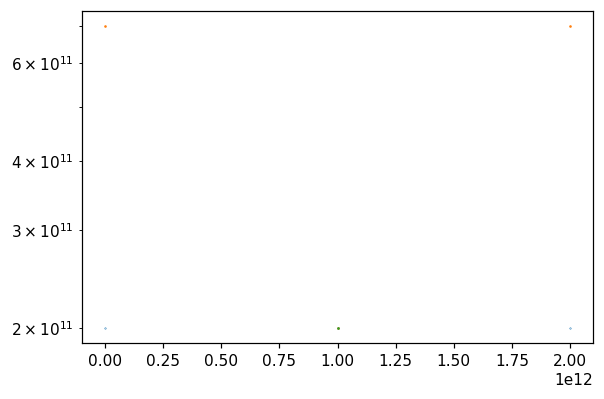

In [131]:
plt.figure(dpi=110)
plt.scatter(np.linalg.norm(Xs_all, axis=1), mdis, s=0.1)
plt.scatter(np.linalg.norm(Xs_all, axis=1), mdis+sdis, s=0.5)
plt.scatter(np.linalg.norm(Xs_all, axis=1), mdis-sdis, s=0.5)
# plt.xscale('log')
plt.yscale('log')

In [132]:
alpha2 = 1.0

@njit
def kerval(inverse_h2, d):
    return alpha2 * np.exp(-0.5 * inverse_h2 * np.dot(d, d))

@njit
def kernel(r, p1, p2):
    d = Xs_all[p1] - Xs_all[p2]
    inverse_h2 = 0.5*(inverse_mdis2[p1] + inverse_mdis2[p2])
    return kerval(inverse_h2, d)

@njit
def L1_kernel(r, p1, p2):
    d = Xs_all[p1] - Xs_all[p2]
    inverse_h2 = 0.5*(inverse_mdis2[p1] + inverse_mdis2[p2])
    g = np.dot(d, Rs[r]) * inverse_h2
    return (chi[p1] - g) * kerval(inverse_h2, d)

@njit
def L2_kernel(r, p1, p2):
    d = Xs_all[p1] - Xs_all[p2]
    inverse_h2 = 0.5*(inverse_mdis2[p1] + inverse_mdis2[p2])
    g = np.dot(d, Rs[r]) * inverse_h2
    return (chi[p2] + g) * kerval(inverse_h2, d)

@njit
def L12_kernel(r, p1, p2):
    d = Xs_all[p1] - Xs_all[p2]
    inverse_h2 = 0.5*(inverse_mdis2[p1] + inverse_mdis2[p2])
    g = np.dot(d, Rs[r]) * inverse_h2
    return ((chi[p1] + g)*(chi[p2] - g) + inverse_h2) * kerval(inverse_h2, d)

In [133]:
npoints   = model.parameters.npoints()
nboundary = model.parameters.nboundary()
matsize   = npoints + nboundary

@njit
def get_expansion(r):
    # define shape
    nrows = matsize
    ncols = ncp
    # initialize
    expansion = np.zeros((nrows, ncols))
    # compute
    for i1, p1 in enumerate(boundary2point):
        for i2, p2 in enumerate(ind_bdy[i1]):
            expansion[i1,i2] =    kernel(r, p1, p2)
    for p1, i1 in enumerate(range(nboundary, nrows)):
        for i2, p2 in enumerate(ind_all[p1]):
            expansion[i1,i2] = L2_kernel(r, p1, p2)
    return expansion

@njit
def get_covariance(r):
    # define shape
    nrows = matsize
    ncols = nrows
    # initialize
    data = np.zeros((2*nrows*ncp), dtype=np.float64)
    id_i = np.zeros((2*nrows*ncp), dtype=np.int64)
    id_j = np.zeros((2*nrows*ncp), dtype=np.int64)
    # set index
    index = 0
    # compute
    for i1, p1 in enumerate(boundary2point):
        for i2, p2 in enumerate(ind_bdy[i1]):
            data[index] = kernel(r, p1, p2)
            id_i[index] = i1
            id_j[index] = i2
            index += 1
        for i2, p2 in enumerate(ind_all[p1]):
            data[index] = L2_kernel(r, p1, p2)
            id_i[index] = i1
            id_j[index] = i2 + nboundary
            index += 1
            data[index] = L1_kernel(r, p2, p1)
            id_i[index] = i2 + nboundary
            id_j[index] = i1
            index += 1
    for p1, i1 in enumerate(range(nboundary, nrows)):
        for i2, p2 in enumerate(ind_all[p1]):
            data[index] = L12_kernel(r, p1, p2)
            id_i[index] = i1
            id_j[index] = i2 + nboundary
            index += 1
    return (data, (id_i, id_j))

@njit
def get_condition(r):
    # define shape
    nrows = npoints + nboundary
    # initialize
    condition = np.zeros(nrows)
    # compute
    condition[:nboundary]      = boundary_condition
    condition[nboundary:nrows] = eta
    return condition

In [134]:
r = 0

covariance = sparse.coo_matrix(get_covariance(r), shape=(matsize, matsize)).tocsc()
condition  = get_condition(r)
expansion  = get_expansion(r)
weights    = sparse.linalg.spsolve(covariance, condition)
result     = np.matmul(expansion.T, weights)

In [135]:
# ld = model.lines.lineProducingSpecies[0].linedata

# k = 0

# frq_ = ld.frequency[k]
# pop_ = tools.LTEpop         (ld, temp) * get_X_mol['a'] * nH2_in
# phi_ = tools.profile        (ld, k, temp, (turb/magritte.CC)**2, frq_)
# eta_ = tools.lineEmissivity (ld, pop_)[k] * phi_
# chi_ = tools.lineOpacity    (ld, pop_)[k] * phi_
# src_ = tools.lineSource     (ld, pop_)[k]
# bdy_ = tools.I_CMB          (frq_)

# def I_0 (x):
#     a = src_
#     b = (bdy_-src_)
#     c = np.exp(-chi_*r_in*(1.0    - r_in/x    ))
#     return a+b*c

# def I_1 (x):
#     return src_ + (bdy_-src_)*np.exp(-chi_*r_in*(r_in/x - r_in/r_out))
# 
# plt.plot(x, I_0(x))
# plt.plot(x, I_1(x))

In [136]:
result

array([-2.62638047e-17, -4.16711443e-20, -3.77300412e-18])

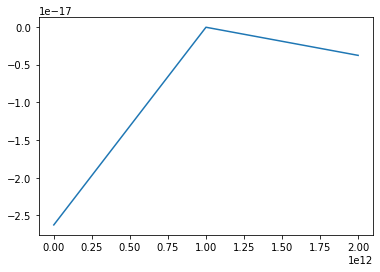

In [137]:
plt.plot(rs, result)
# plt.plot(rs, I_0(rs))
# plt.plot(rs, I_1(rs))
# plt.xscale('log')
# plt.yscale('log')

# Test
---

In [138]:
x = rs

In [139]:
chi_int = interp1d(rs, chi)

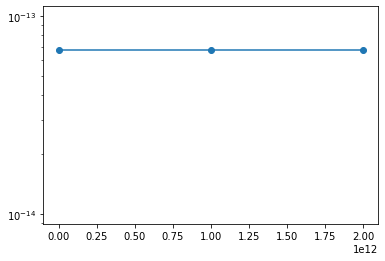

In [140]:
plt.plot(x, chi_int(x))
# plt.scatter(x, eta)
plt.scatter(x, chi)
plt.yscale('log')

In [143]:
alpha = 1.0

def kernel(x, y, h):
    result = alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)
    result[result<1.0e-9] = 0.0 
    return result

def Lx_kernel(x, y, h):
    """
    (chi(x) + d_x) k(x,y)
    """
    g = (x-y)/h**2
    return (chi_int(x) - g) * kernel(x, y, h)

def Ly_kernel(x, y, h):
    """
    (chi(y) + d_y) k(x,y)
    """
    g = (x-y)/h**2
    return (chi_int(y) + g) * kernel(x, y, h)

def L2_kernel(x, y, h):
    """
    (chi(x) + d_x) (chi(y) + d_y) k(x,y)
    """
    g = (x-y)/h**2
    return ((chi_int(x)+g) * (chi_int(y)-g) + 1.0/h**2) * kernel(x, y, h)

In [142]:
alpha = 1.0

def kernel(x, y, h):
    return alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)


def Lx_dd(x, y, h):
    """
    d_x k(x,y)
    """
    return -(x-y)/h**2 * kernel(x, y, h)

def Lx_od(x, y, h):
    """
    chi(x) k(x,y)
    """
    return chi_int(x) * kernel(x, y, h)


def Ly_dd(x, y, h):
    """
    d_y k(x,y)
    """
    return  (x-y)/h**2 * kernel(x, y, h)

def Ly_od(x, y, h):
    """
    chi(y) k(x,y)
    """
    return chi_int(y) * kernel(x, y, h)


def L2_dd(x, y, h):
    """
    (d_x d_y + chi(x) chi(y)) k(x,y)
    """
    return (chi_int(x)*chi_int(y)*h**4 + h**2 - (x-y)**2) / h**4 * kernel(x, y, h)

def L2_od(x, y, h):
    """
    (chi(x) d_y + chi(y) d_x) k(x,y)
    """
    return (chi_int(x)-chi_int(y))*(x-y) / h**2 * kernel(x, y, h)

In [81]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_dd_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_dd(x, y, h).T

def Lx_od_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_od(x, y, h).T

def Ly_dd_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_dd(x, y, h).T

def Ly_od_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_od(x, y, h).T

def L2_dd_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_dd(x, y, h).T

def L2_od_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_od(x, y, h).T

In [144]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_kernel(x, y, h).T

def Ly_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_kernel(x, y, h).T

def L2_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_kernel(x, y, h).T

In [145]:
def diff(x, y):
    # Compute derivative
    dy = np.diff(y)
    dx = np.diff(x)
    # Compute corresponding x
    x = 0.5*(x[:-1] + x[1:])
    # Return result
    return (x, dy/dx)

def L_operator(x, y):
    x_d, y_d = diff(x, y)
    y_y = 0.5*(y[:-1] + y[1:])
    return (x_d, chi_int(x_d)*y_y + y_d)

In [146]:
import ipywidgets as widgets

x_min = np.min(x)
x_max = np.max(x)

In [147]:
boundary_condition

array([3.77281369e-18, 3.77281369e-18])

In [148]:
 np.concatenate((rs,  rs               )) 

array([0.e+00, 1.e+12, 2.e+12, 0.e+00, 1.e+12, 2.e+12])

In [149]:
y_p  = np.array([rs[0]])
fy_p = np.array([boundary_condition[0]])

y_d  = rs #np.linspace(0.0, 2.0, num=5)
fy_d = eta #np.array([eta(d) for d in y_d])


def plot(h):
    
#     x = np.array([0.1])
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

#     print(   corr(y_p, y_p, h).shape)
#     print(Lx_corr(y_d, y_p, h).T.shape)
#     print(Ly_corr(y_p, y_d, h).shape)
#     print(L2_corr(y_d, y_d, h).shape)
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
    print('sigma_10 ', sigma_10.shape)
    print('sigma_11 ', sigma_11.shape)
    
    fy = np.block([fy_p, fy_d])

    print(np.min(sigma_11), np.max(sigma_11))
    inv = np.linalg.inv(sigma_11)
    print(np.min(inv     ), np.max(inv     ))

    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6), dpi=175)
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(np.linalg.inv(sigma_11), cmap='Spectral')
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
#     ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75, marker='x')
#     ax3.set_yscale('log')
    ax3.plot(x, I_0(x), linewidth=0.75)
#     ax3.plot(x, I_1(x), linewidth=0.75)
#     ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
#     ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

#     ax3.plot(x, np.exp(-x), linewidth=0.75)
    
#     for s in range(S):
#         xs, Ls = L_operator(x, fs[:,s])
#         ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))
    ax4.set_yscale('log')
    ax4.plot(x, eta, linewidth=0.75)
    
    plt.show()
    
widgets.interact(plot, h=(rs[0], rs[-1], dx))

interactive(children=(FloatSlider(value=1000000000000.0, description='h', max=2000000000000.0, step=1000000000…

<function __main__.plot(h)>

In [88]:
y_p  = np.array([rs[0],                 rs[-1]])                 #np.array([0.0])
fy_p = np.array([boundary_condition[0], boundary_condition[-1]]) #np.array([1.0])

y_d  = np.concatenate((rs,  rs               ))  #np.linspace(0.0, 2.0, num=5)
fy_d = np.concatenate((eta, np.zeros(npoints)))  #eta #np.array([eta(d) for d in y_d])




def plot(h):
    
    print('h = ', h/rs[-1])
    
#     x = np.array([0.1])
    
#     sigma_00 = corr(x, x, h)
    
    kxx = corr(x, x, h)
    sigma_00 = np.block([[kxx,                     np.zeros(kxx.shape)],
                         [np.zeros(kxx.shape),     kxx                ] ])

    kxy_p = corr(x, y_p, h)
    sigma_10 = np.block([[kxy_p,                   np.zeros(kxy_p.shape)],
                         [np.zeros(kxy_p.shape),   kxy_p                ],
                         [Ly_dd_corr(x, y_d, h),   Ly_od_corr(x, y_d, h)],
                         [Ly_od_corr(x, y_d, h),   Ly_dd_corr(x, y_d, h)]])
     
    kyx_p = corr(y_p, x, h)
    sigma_01 = np.block([[kyx_p                .T, np.zeros(kyx_p.shape).T],
                         [np.zeros(kyx_p.shape).T, kyx_p                .T],
                         [Lx_dd_corr(y_d, x, h).T, Lx_od_corr(y_d, x, h).T],
                         [Lx_od_corr(y_d, x, h).T, Lx_dd_corr(y_d, x, h).T] ]).T
    

    
#     print(   corr(y_p, y_p, h).shape)
#     print(Lx_corr(y_d, y_p, h).T.shape)
#     print(Ly_corr(y_p, y_d, h).shape)
#     print(L2_corr(y_d, y_d, h).shape)
    
    kyy_p = corr(y_p, y_p, h)
    sigma_11 = np.block([[kyx_p,                     np.zeros(kyx_p.shape),     Ly_dd_corr(y_p, y_d, h).T, Ly_od_corr(y_p, y_d, h).T],
                         [np.zeros(kyx_p.shape),     kyx_p,                     Ly_od_corr(y_p, y_d, h).T, Ly_dd_corr(y_p, y_d, h).T],
                         [Lx_dd_corr(y_d, y_p, h).T, Lx_od_corr(y_d, y_p, h).T, L2_dd_corr(y_d, y_d, h),   L2_od_corr(y_d, y_d, h)  ],
                         [Lx_od_corr(y_d, y_p, h).T, Lx_dd_corr(y_d, y_p, h).T, L2_od_corr(y_d, y_d, h),   L2_dd_corr(y_d, y_d, h)  ] ])
        
#     sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
#                          [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
    print('sigma_10 ', sigma_10.shape)
    print('sigma_11 ', sigma_11.shape)
    
    fy = np.block([fy_p, fy_d])

    print(fy_p.shape)
    print(fy_d.shape),
    print(fy.shape)
    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,13), dpi=175)
    gsp = fig.add_gridspec(14, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])
    ax5 = fig.add_subplot(gsp[8:11, 0:2])
    ax6 = fig.add_subplot(gsp[11:14, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf/x[-1], kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$ [r_out]')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    pos = ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax2)
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
#     ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75, marker='x')
#     ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
#     ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    ax3.plot(x, I_0(x), linewidth=0.75)
    ax3.plot(x, I_1(x), linewidth=0.75)
    ax3.set_yscale('log')
    
#     for s in range(S):
#         xs, Ls = L_operator(x, fs[:,s])
#         ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.plot(x, eta, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))
    ax4.set_yscale('log')
    
    
    ax5.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    pos = ax5.imshow(cov)
    ax5.set_xlabel('index $i$')
    ax5.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax5)
    
    
    ax6.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    pos = ax6.imshow(sigma_11)
    ax6.set_xlabel('index $i$')
    ax6.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax6)
    
    plt.show()
    
widgets.interact(plot, h=(x[0], x[-1]))

interactive(children=(FloatSlider(value=24500000000000.0, description='h', max=49000000000000.0), Output()), _…

<function __main__.plot(h)>

In [40]:
h = rs[-1]

sigma_11 = np.block([[   corr(y_p, y_p, h),   Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

In [41]:
ss = np.copy(sigma_11)

In [42]:
ss[ss<1.0e-50] = 0.0

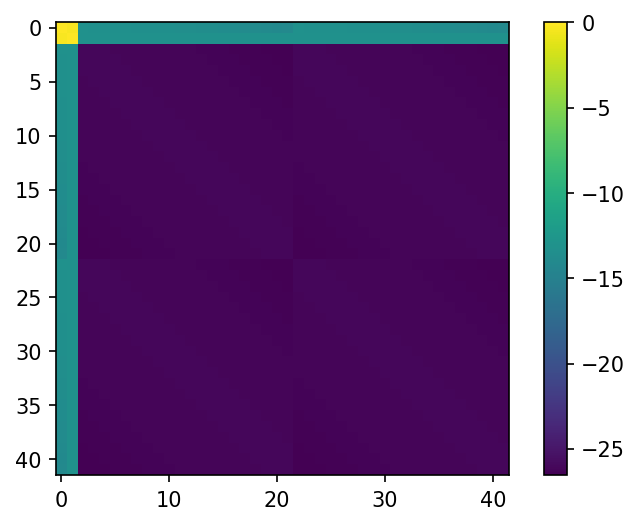

In [43]:
fig = plt.figure(dpi=150)
pos = plt.imshow(np.log10(np.abs(ss)))
fig.colorbar(pos)

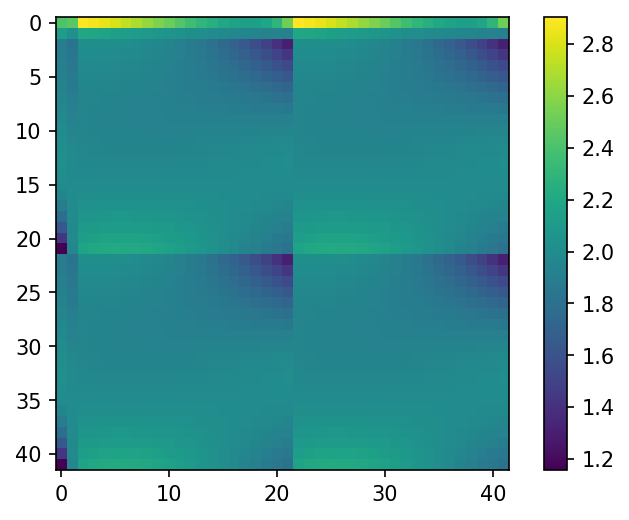

In [44]:
fig = plt.figure(dpi=150)
pos = plt.imshow(tools.relative_error(ss, np.linalg.inv(np.linalg.inv(ss))))
fig.colorbar(pos)

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


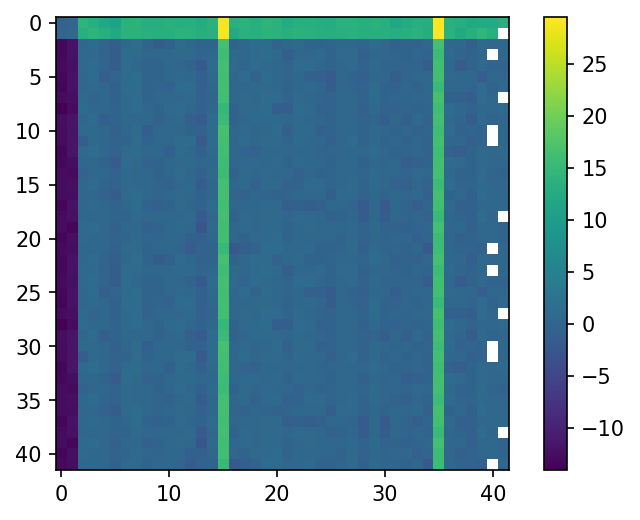

In [45]:
fig = plt.figure(dpi=150)
pos = plt.imshow(np.log10(np.abs(np.matmul(ss, np.linalg.inv(ss)))))
fig.colorbar(pos)

In [46]:
h = rs[1]

sigma_11 = np.block([[   corr(y_p, y_p, h),   Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

In [47]:
def plot(h):
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T
    
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

    
    fy = np.block([fy_p, fy_d])

    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(14,16), dpi=175)
    gsp = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gsp[0])
    ax2 = fig.add_subplot(gsp[1])
    ax3 = fig.add_subplot(gsp[2])
    ax4 = fig.add_subplot(gsp[3])
    ax5 = fig.add_subplot(gsp[4])
    ax6 = fig.add_subplot(gsp[5])

#     ax1.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
#     pos = ax1.imshow(cov)
#     ax5.set_xlabel('index $i$')
#     ax5.set_ylabel('index $j$')
#     fig.colorbar(pos, ax=ax5)
    
    
    ax1.set_title('+sigma_11')
    pos = ax1.imshow(np.log10(sigma_11))
#     ax1.set_xlabel('index $i$')
#     ax1.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax1)
    
    ax2.set_title('-sigma_11')
    pos = ax2.imshow(np.log10(-sigma_11))
#     ax2.set_xlabel('index $i$')
#     ax2.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax2)
    
    ax3.set_title('+cov')
    pos = ax3.imshow(np.log10(cov))
#     ax3.set_xlabel('index $i$')
#     ax3.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax3)
    
    ax4.set_title('-cov')
    pos = ax4.imshow(np.log10(-cov))
#     ax4.set_xlabel('index $i$')
#     ax4.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax4)
    
    ax5.set_title('+inverse_sigma_11')
    pos = ax5.imshow(np.log10(np.linalg.inv(sigma_11)))
#     ax5.set_xlabel('index $i$')
#     ax5.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax5)
    
    ax6.set_title('-inverse_sigma_11')
    pos = ax6.imshow(np.log10(-np.linalg.inv(sigma_11)))
#     ax4.set_xlabel('index $i$')
#     ax4.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax6)
    
    plt.show()
    
widgets.interact(plot, h=(x[0], x[-1]))

interactive(children=(FloatSlider(value=9500000000000.0, description='h', max=19000000000000.0), Output()), _d…

<function __main__.plot(h)>

In [48]:
def plot(h):
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T
    
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

    
    fy = np.block([fy_p, fy_d])

    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(14,16), dpi=100)
    gsp = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gsp[0])
    ax3 = fig.add_subplot(gsp[1])


#     ax1.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
#     pos = ax1.imshow(cov)
#     ax5.set_xlabel('index $i$')
#     ax5.set_ylabel('index $j$')
#     fig.colorbar(pos, ax=ax5)
    
    
    ax1.set_title('+sigma_11')
    pos = ax1.imshow(np.log10(tools.relative_error(sigma_11, sigma_11.T)))
#     ax1.set_xlabel('index $i$')
#     ax1.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax1)
    
    ax3.set_title('+cov')
    pos = ax3.imshow(np.log10(tools.relative_error(cov, cov.T)))
#     ax3.set_xlabel('index $i$')
#     ax3.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax3)
    
    plt.show()

    print(tools.relative_error(sigma_11, sigma_11.T))
    print(tools.relative_error(cov,      cov.T     ))
    
widgets.interact(plot, h=(x[0], x[-1]))

interactive(children=(FloatSlider(value=9500000000000.0, description='h', max=19000000000000.0), Output()), _d…

<function __main__.plot(h)>

In [72]:
def mylog(x):
    result = np.zeros(x.shape)
    result[x>0] =  np.log(x[x>0])
#     result[x<0] = -np.log(x[x<0])
    return result

In [73]:
mylog(sigma_11)

array([[  0.        , -30.32661851,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-30.32661851, -55.25749606, -61.15323702,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        , -61.15323702, -55.25749606, -61.15323702,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.    

array([[ 0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -

In [139]:
sigma_00 = corr(x, x, h)

sigma_10 = np.block([   corr(x, y_p, h),
                     Ly_corr(x, y_d, h) ])
    
sigma_01 = np.block([   corr(y_p, x, h).T,
                     Lx_corr(y_d, x, h).T ]).T
    
sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

fy = np.block([fy_p, fy_d])

In [148]:
sigma_11.shape

(4, 4)

In [147]:
covariance.toarray().shape

(5, 5)

In [146]:
fy

array([3.77281369e-18, 9.97040097e-31, 9.97040097e-31, 9.97040097e-31])

In [145]:
condition

array([3.77281369e-18, 3.77281369e-18, 9.97040097e-31, 9.97040097e-31,
       9.97040097e-31])